In [1]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

In [2]:
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

In [3]:
patient = "S010"

In [51]:
raw_open = get_raw(f'data/eegmmidb/files/{patient}/{patient}R01.edf', filter=True, resample=False, high_pass=30, low_pass=70)
annotation_open = get_annotations(f'data/eegmmidb/files/{patient}/{patient}R01.edf')
raw_open = get_window_dict(raw_open, annotation_open)['T0'][0]

In [52]:
raw_closed = get_raw(f'data/eegmmidb/files/{patient}/{patient}R02.edf', filter=True, resample=False, high_pass=30, low_pass=70)
annotation_closed = get_annotations(f'data/eegmmidb/files/{patient}/{patient}R02.edf')
raw_closed = get_window_dict(raw_closed, annotation_closed)['T0'][0]

In [53]:
random_edf_file_path = 'notebooks/S001R03.edf' 
mmidb_path = Path(r"/home/s194260/BENDR-XAI/data/eegmmidb/files")
parcellation_name = "aparc.a2009s"

info = get_raw(random_edf_file_path, filter=True).info # Just need one raw to get info
src = get_src(src_path)
fwd = get_fwd(info, trans, src_path, bem_path)

labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

sfreq = int(raw_open.info['sfreq'])

vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

Effective window size : 1.600 (s)


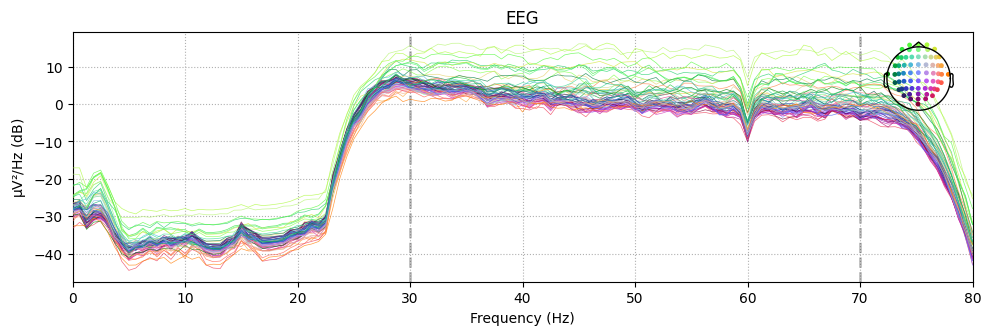

In [54]:
raw_open.compute_psd().plot()
plt.show()

Effective window size : 1.600 (s)


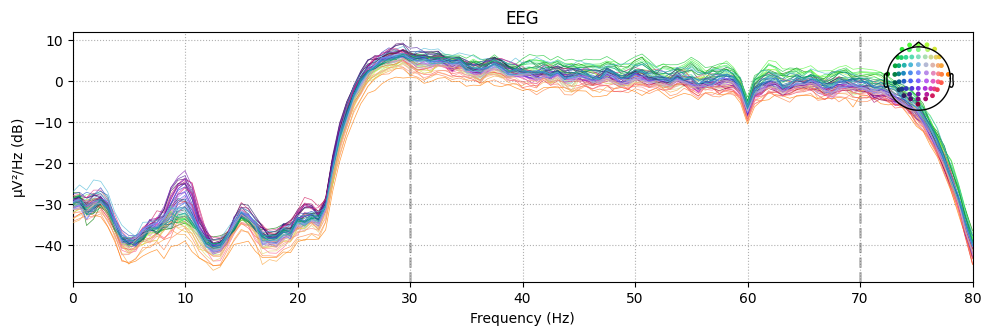

In [55]:
raw_closed.compute_psd().plot()
plt.show()

In [56]:
cov_open = get_cov(raw_open)
cov_closed = get_cov(raw_closed)
#compute_inverse = make_fast_inverse_operator(raw_open.info, fwd, cov, snr=snr)

In [70]:
verbose = False
method = "eLORETA"
snr = 100
max_iter = 100
nave = 1
lambda2 = 1/snr**2
inv_open = mne.minimum_norm.make_inverse_operator(info, fwd, cov_open, verbose=verbose)
inv_open = mne.minimum_norm.prepare_inverse_operator(inv_open, nave, lambda2, method=method, method_params={'max_iter': max_iter}, verbose=verbose)

inv_closed = mne.minimum_norm.make_inverse_operator(info, fwd, cov_closed, verbose=verbose)
inv_closed = mne.minimum_norm.prepare_inverse_operator(inv_closed, nave, lambda2, method=method, method_params={'max_iter': max_iter}, verbose=verbose)

In [71]:
visual_region_labels = [[label  for label in labels[hemi] if "occipital" in label.name] for hemi in range(2)]

In [72]:
stc_open = mne.minimum_norm.apply_inverse_raw(raw_open, inv_open, lambda2, method=method, method_params={'max_iter': max_iter}, prepared=True, verbose=verbose)
stc_closed = mne.minimum_norm.apply_inverse_raw(raw_closed, inv_closed, lambda2, method=method, method_params={'max_iter': max_iter}, prepared=True, verbose=verbose)

activity_open = get_power_per_label(stc_open, visual_region_labels, standardize=False)
activity_closed = get_power_per_label(stc_closed, visual_region_labels, standardize=False)

activity_open = np.concatenate(activity_open)
activity_closed = np.concatenate(activity_closed)

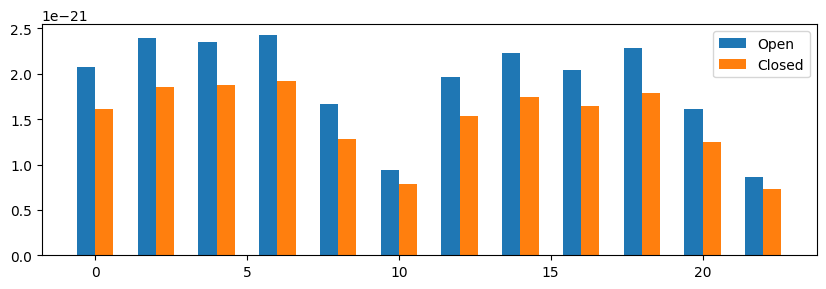

In [69]:
# Bar plot comparing activity_open and activity_closed
width = 0.6

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(np.arange(len(activity_open))*2 - width/2, activity_open, label="Open", width=0.6)
ax.bar(np.arange(len(activity_closed))*2 + width/2, activity_closed, label="Closed", width=0.6)
ax.legend()
plt.show()

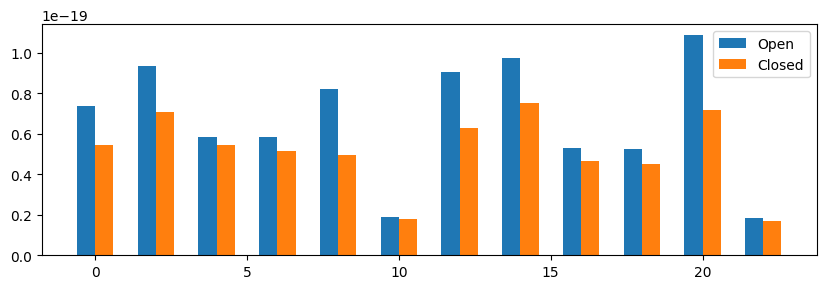

In [ ]:
# Bar plot comparing activity_open and activity_closed
width = 0.6

fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(np.arange(len(activity_open))*2 - width/2, activity_open, label="Open", width=0.6)
ax.bar(np.arange(len(activity_closed))*2 + width/2, activity_closed, label="Closed", width=0.6)
ax.legend()
plt.show()

In [31]:
snr_array = np.logspace(-4, 4, 50)
result = []

for snr in tqdm(snr_array):
    lambda2 = 1/snr**2
    inv_open = mne.minimum_norm.make_inverse_operator(info, fwd, cov_open, verbose=verbose)
    inv_open = mne.minimum_norm.prepare_inverse_operator(inv_open, nave, lambda2, method=method, method_params={'max_iter': max_iter}, verbose=verbose)

    inv_closed = mne.minimum_norm.make_inverse_operator(info, fwd, cov_closed, verbose=verbose)
    inv_closed = mne.minimum_norm.prepare_inverse_operator(inv_closed, nave, lambda2, method=method, method_params={'max_iter': max_iter}, verbose=verbose)

    stc_open = mne.minimum_norm.apply_inverse_raw(raw_open, inv_open, lambda2, method=method, method_params={'max_iter': max_iter}, prepared=True, verbose=verbose)
    stc_closed = mne.minimum_norm.apply_inverse_raw(raw_closed, inv_closed, lambda2, method=method, method_params={'max_iter': max_iter}, prepared=True, verbose=verbose)

    activity_open = get_power_per_label(stc_open, visual_region_labels, standardize=False)
    activity_closed = get_power_per_label(stc_closed, visual_region_labels, standardize=False)

    activity_open = np.concatenate(activity_open)
    activity_closed = np.concatenate(activity_closed)

    result.append(activity_closed - activity_open)

100%|██████████| 50/50 [26:59<00:00, 32.38s/it]


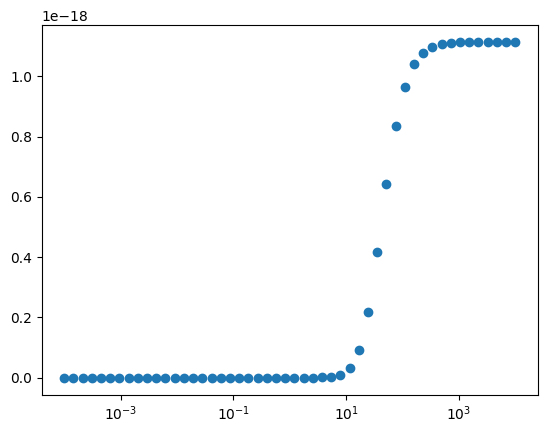

In [46]:
plt.scatter(snr_array, np.array(result))
plt.xscale('log')
plt.show()

In [42]:
snr_array

array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511374e-02, 1.26485522e-01,
       1.84206997e-01, 2.68269580e-01, 3.90693994e-01, 5.68986603e-01,
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])

In [41]:
np.array(result)

array([-1.75558215e-37, -7.89737968e-37, -3.55259411e-36, -1.59812106e-35,
       -7.18914042e-35, -3.23408222e-34, -1.45492152e-33, -6.54573852e-33,
       -2.94538831e-32, -1.32575661e-31, -5.97139334e-31, -2.69340156e-30,
       -1.21847046e-29, -5.54632204e-29, -2.55639012e-28, -1.20715626e-27,
       -5.94831047e-27, -3.11849714e-26, -1.73703842e-25, -9.74448310e-25,
       -4.95352853e-24, -2.06297828e-23, -6.70394125e-23, -1.65744589e-22,
       -2.96958720e-22, -3.34591279e-22, -7.46602683e-23,  5.83028393e-22,
        1.66303322e-21,  3.88182117e-21,  1.04994498e-20,  3.18982866e-20,
        9.16356682e-20,  2.18730979e-19,  4.17350578e-19,  6.44047006e-19,
        8.36708548e-19,  9.65843919e-19,  1.03957407e-18,  1.07790385e-18,
        1.09686398e-18,  1.10601216e-18,  1.11037307e-18,  1.11243992e-18,
        1.11341680e-18,  1.11387793e-18,  1.11409546e-18,  1.11419805e-18,
        1.11424643e-18,  1.11426924e-18])

In [13]:
occi_open = np.mean([activity_open[hemi][i] for hemi in range(2) for i, label in enumerate(labels[hemi]) if 'occipital' in label.name])
occi_closed = np.mean([activity_closed[hemi][i] for hemi in range(2) for i, label in enumerate(labels[hemi]) if 'occipital' in label.name])

In [23]:
tmp_open = np.load('mmidb_aparc.a2009s_1.0_8.0_12.0_parallel.npy', allow_pickle=True).item()[patient][f'{patient}R01']['T0']
tmp_closed = np.load('mmidb_aparc.a2009s_1.0_8.0_12.0_parallel.npy', allow_pickle=True).item()[patient][f'{patient}R02']['T0']

In [ ]:
color = np.mean(stc_closed.data, axis=1)
# Standardize color between 0 and 1
color = (color - np.min(color)) / (np.max(color) - np.min(color))
color = color.reshape(2, 10242)
#tris_values = vertex_values_to_tris_values(color, tris_sources, func=np.max)

In [ ]:
activity_open = get_power_per_label(stc_open, labels, standardize=False)
values = activity_to_source_values(activity_open, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

In [120]:
activity = [[None]*len(labels[0]), [None]*len(labels[1])]

In [121]:
for hemi in range(2):
    for i, label in enumerate(labels[hemi]):
        if 'occipital' in label.name:
            activity[hemi][i] = 1
        else:
            activity[hemi][i] = 0

In [122]:
values = activity_to_source_values(activity, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

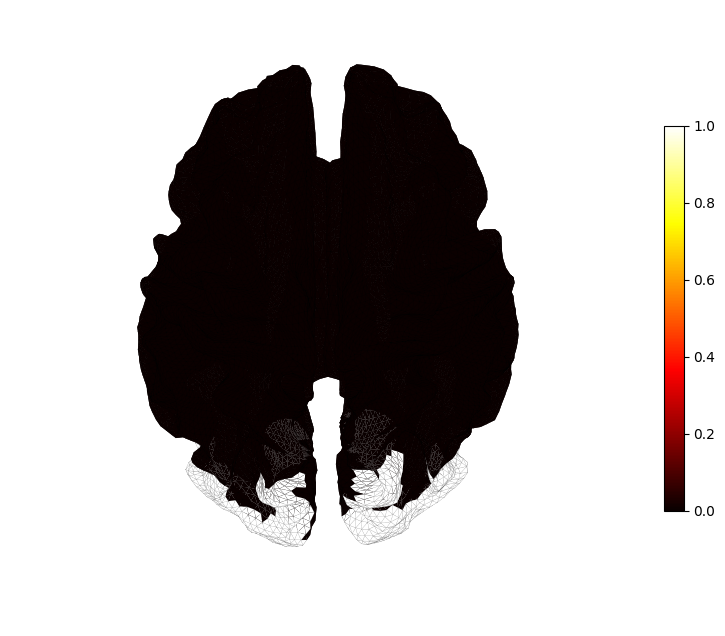

In [141]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

lh_mesh.set_array(tris_values[0])
#fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, -90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout()
plt.show()